<a href="https://colab.research.google.com/github/GZabalaG/AIMaster/blob/main/Supervised/Actividad_Portfolio_Gonzalo_ZabalaGarcia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import cv2 as cv
import os

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
histo = ''
def savefile(img, path, filename):
  cv.imwrite(os.path.join(path , filename), img)

#### Cargar una de las imágenes histológicas

In [24]:
# Utiliza la librería skimage.io para leer la imagen 'histo_x.jpg' y visualízala usando la librería de matplotlib.
from skimage import io
import matplotlib.pyplot as plt

histo_1 = io.imread('/content/drive/MyDrive/Master IA/Aprendizaje Supervisado/histo_1.jpeg')
histo_2 = io.imread('/content/drive/MyDrive/Master IA/Aprendizaje Supervisado/histo_2.jpeg')

#### ELEGIR IMAGEN SOBRE LA QUE REALIZAR EL PROCESADO ###
histo_x = histo_1
histo_file = 'histo1'

# Crea directiorio si no existe en drive. En ese directorio guarda las imágenes generadas
dir = '/content/drive/MyDrive/Master IA/Aprendizaje Supervisado/' + histo_file
os.makedirs(dir, exist_ok=True)

<function matplotlib.pyplot.show>

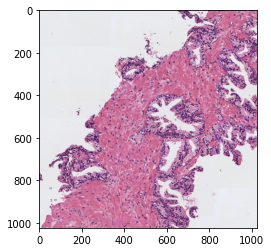

In [25]:
# Recuerda normalizar la imagen diviéndola entre 255
histo_x = histo_x/255
plt.imshow(histo_x, cmap='gray')
plt.show

#### Realizar una transformación de color para convertir la imagen al espacio de color CMYK

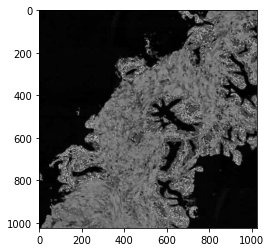

In [26]:
# 1) Extrae la componente magenta de la imagen (que corresponde a la región tisular)
with np.errstate(invalid='ignore', divide='ignore'):
   k = 1 - np.max(histo_x, axis=2)
   m = (1-histo_x[...,1] - k)/(1-k)

# 2) Visualiza la imagen con la librería de matplotlib.
plt.imshow(m, cmap='gray')

# 3) Guarda la imagen Magenta con cv2.imwrite con el nombre "1_imagen_magenta.png"
savefile((m*255).astype('uint8'), dir, '1_imagen_magenta.png')

#### Umbralizar la imagen para separar los píxeles del fondo de la región tisular

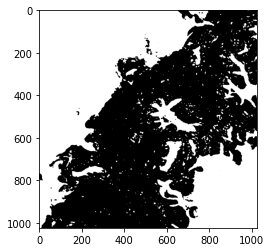

In [27]:
# 1) Convierte la imagen Magenta a formato "uint8"
mu8 = (m*255).astype('uint8')

# 2) Aplica un filtro gaussiano de tamaño 5x5
gauss = cv.GaussianBlur(mu8,(5,5),0)

# 3) Umbraliza la imagen aplicando el método de Otsu
# 4) Aplica el umbral de manera que los píxeles del fondo y de los lúmenes sean 1s y el resto 0s. 
t, mask = cv.threshold(gauss, 0, 1, cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

# 5) Visualiza la máscara resultante (imagen de 0s y 1s)
plt.imshow(mask, cmap='gray')

# 6) Guarda la máscara multiplicándola por 255 con el nombre "2_mascara_con_artefactos.png"
mask = mask * 255
savefile(mask, dir, '2_mascara_con_artefactos.png')

#### Limpiar la imagen eliminando los artefactos de lumen (objetos blancos pequeños que no son lúmenes)

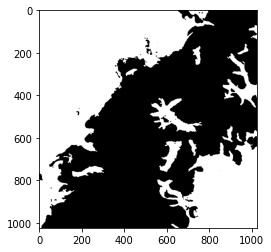

In [28]:
# 1) Utiliza la librería skimage.morphology.remove_small_objects. 
# Lee la documentación en https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects
# Fija el umbral en 300 píxeles y la conectividad del objeto en 8 píxeles.
from skimage import morphology

removed = morphology.remove_small_objects((mask//255).astype(bool), 300, connectivity=8)

# 2) Convierte la máscara generada en formato uint8
removed = removed.astype('uint8')

# 3) Visualiza la máscara resultante
plt.imshow(removed, cmap='gray')

# 4) Guarda la máscara multiplicándola por 255 con el nombre "3_mascara_sin_artefactos.png"
removed = removed * 255
savefile(removed, dir, '3_mascara_sin_artefactos.png')

#### Rellenar con 0s el fondo de la imagen para quedarnos únicamente con los lúmenes

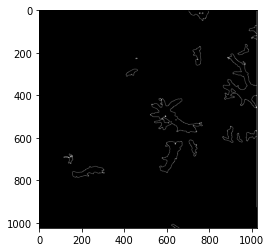

In [29]:
# 1) Aplica el algoritmo de expansión a partir de semillas para rellenar con 0s
# Pon dos semillas: una en la esquina superior izquierda y otra en la esquina inferior derecha.
pre_canny = removed // 255

# Dibujamos una linea en la derecha de la imagen 1 para poder captar los lúmenes que sobresalen de la imagen
def plot_lines(img, color = (255, 255, 255)):
  height, width = img.shape
  x1, y1 = width-1, 1
  x2, y2 = width-1, height-100
  cv.line(img, (x1, y1), (x2, y2), color, 2)

plot_lines(pre_canny)

h, w = pre_canny.shape
ref1 = np.zeros((h+2, w+2), np.uint8)
cv.floodFill(pre_canny, ref1, (0,0), 0)
cv.floodFill(pre_canny, ref1, (pre_canny.shape[0]-1,pre_canny.shape[1]-1), 0)

### PASO EXTRA: El siguiente enunciado estaría completo sin sacar contornos con canny. 
# Como se pide rellenar con binary_fill_holes se necesita partir de una máscara con objetos identificados
canny = cv.Canny(pre_canny, 1/3, 1)
kernel = np.ones((2,2), 'uint8')
canny = cv.dilate(canny, kernel, iterations=2)
canny = cv.erode(canny, kernel, iterations=2)

# 2) Visualiza la máscara resultante
plt.imshow(canny, cmap='gray')
plt.show()

# 3) Guarda la máscara multiplicándola por 255 con el nombre "4_mascara_lumenes.png"
savefile(canny, dir, '4_mascara_lumenes.png')

#### Rellenar los objetos de los lúmenes

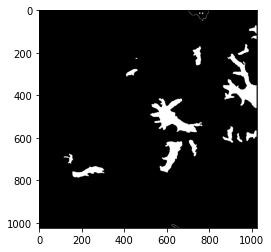

In [30]:
# 1) Rellena los lúmenes con la función binary_fill_holes de la librería scipy.ndimage.morphology
# 2) Convierte la máscara resultante en formato uint8
from scipy import ndimage

bin_fill = ndimage.morphology.binary_fill_holes(canny).astype('uint8')

### Borramos las lineas auxiliares:
plot_lines(bin_fill, (0,0,0))

# 3) Visualiza la máscara
plt.imshow(bin_fill, cmap='gray')

# 4) Guarda la máscara multiplicándola por 255 con el nombre "5_mascara_final.png"
bin_fill = bin_fill * 255
savefile(bin_fill, dir, '5_mascara_final.png')

#### Detectar y dibujar los contornos de los lúmenes sobre la imagen original

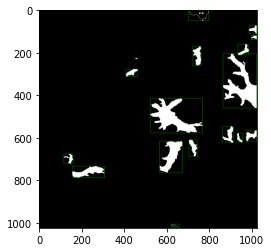

In [31]:
# 1) Encuentra los contornos de los lúmenes

contours, hierarchy = cv.findContours(bin_fill, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

rgb_contour = cv.cvtColor(bin_fill,cv.COLOR_GRAY2RGB)

# 2) Dibuja los contornos (de color verde) sobre la imagen original
for contour in contours:
    x,y,w,h = cv.boundingRect(contour)
    cv.rectangle(rgb_contour,(x,y),(x+w,y+h),(0,255,0),1)

# 3) Visualiza la imagen superpuesta
plt.imshow(rgb_contour, cmap='gray')

# 4) Guarda la imagen multiplicándola por 255 con el nombre "6_imagen_superpuesta.png"
savefile(rgb_contour, dir, '6_imagen_superpuesta.png')

#### Identificar y cropear el lumen más grande

Areas (pixels):

Area lumen 1 = 183
Area lumen 2 = 32
Area lumen 3 = 36
Area lumen 4 = 646
Area lumen 5 = 256
Area lumen 6 = 922
Area lumen 7 = 2031
Area lumen 8 = 14308
Area lumen 9 = 35
Area lumen 10 = 956
Area lumen 11 = 14709
Area lumen 12 = 1622
Area lumen 13 = 1281
Area lumen 14 = 457
Area lumen 15 = 1424
Area lumen 16 = 6852
Area lumen 17 = 700
Area lumen 18 = 3891
Area lumen 19 = 73


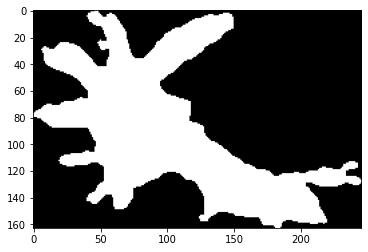

In [32]:
# 1) Convierte la máscara de lúmenes en una imagen de etiquetas utilizando la librería skimage.measure
from skimage.measure import regionprops
from skimage.measure import label

lab, num = label(bin_fill, return_num=True)

v, c = np.unique(lab, return_counts=True)

# 2) Calcula el área de cada uno de los lúmenes 
print('Areas (pixels):\n')
area1 = lab == 1 # Para el proximo ejercicio. Obtenemos el lumen con mayor area en este bucle para no volver a iterar. Menor coste
for i in range(1,num+1):
  object1 = lab == i
  prop = regionprops(object1.astype('uint8'))
  area = prop[0].area
  if area > regionprops(area1.astype('uint8'))[0].area:
    area1 = lab == i
  print('Area lumen', i, '=', area)

# 3) Obtén una máscara del lumen de mayor área
area1 = area1.astype('uint8')

# 4) Haz un crop (recorte) del lumen de mayor área utilizando las coordenadas de la bounding box
prop = regionprops(area1)
bbox = prop[0].bbox
crop = area1[bbox[0]:bbox[2], bbox[1]:bbox[3]]

# 5) Visualiza la máscara recortada del lumen
plt.imshow(crop, cmap='gray')

# 6) Guarda la imagen multiplicándola por 255 con el nombre "7_crop_image.png"
crop = crop*255
savefile(crop, dir, '7_crop_image.png')

#### Extraer 13 características geométricas que permitan caracterizar el lumen recortado 

In [33]:
# Calcula las siguientes características del crop del lumen anterior, redondeando su valor hasta el cuarto decimal.
# 1) Área
# 2) Área de la bounding box
# 3) Área convexa
# 4) Exentricidad
# 5) Diámetro equivalente
# 6) Extensión
# 7) Longitud del eje mayor
# 8) Longitud del eje menor
# 9) Orientación
# 10) Perímetro
# 11) Solidez
# 12) Compacidad
# 13) Rectangularidad

from tabulate import tabulate
import math

new_lab, new_num = label(crop, return_num=True)

# Extraemos las característicias geométricas
headers = ['','Valor']
A,BB,CA,E,ED,EX,MA,MiA,O,P,S,CO,R = ['area'], ['bbox_area'], ['convex_area'], ['eccentricity'], ['equiv_diameter'], \
['extent'], ['major_axis'], ['minor_axis'], ['orientation'], ['perimeter'], ['solidity'], ['compactness'], ['rectangularity']

for i in range(1,new_num+1):
    objeto = new_lab == i
    prop = regionprops(objeto.astype(np.uint8))
    
    A.append(np.round(prop[0].area, 4))
    BB.append(np.round(prop[0].bbox_area, 4))
    CA.append(np.round(prop[0].convex_area, 4))
    E.append(np.round(prop[0].eccentricity, 4))
    ED.append(np.round(prop[0].equivalent_diameter, 4))
    EX.append(np.round(prop[0].extent, 4))
    MA.append(np.round(prop[0].major_axis_length, 4))
    MiA.append(np.round(prop[0].minor_axis_length, 4))
    O.append(np.round(prop[0].orientation, 4))
    P.append(np.round(prop[0].perimeter, 4))
    S.append(np.round(prop[0].solidity, 4))
    CO.append(np.round(4*math.pi*prop[0].area/prop[0].perimeter**2, 4))
    R.append(np.round(prop[0].area/prop[0].bbox_area, 4))


my_data = [tuple(A), tuple(BB), tuple(CA), tuple(E), tuple(ED), tuple(EX), \
          tuple(MA), tuple(MiA), tuple(O), tuple(P), tuple(S), tuple(CO), tuple(R)]

print(tabulate(my_data, headers=headers))

                     Valor
--------------  ----------
area            14709
bbox_area       40098
convex_area     29530
eccentricity        0.8462
equiv_diameter    136.851
extent              0.3668
major_axis        241.264
minor_axis        128.571
orientation         1.01
perimeter        1209.34
solidity            0.4981
compactness         0.1264
rectangularity      0.3668
